<a href="https://colab.research.google.com/github/tsangrebecca/PersonalProjects/blob/main/Tanzania_Water_Pump_Dataset_from_Kaggle_com.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting whether a water pump in Tanzania needs repair or not using random forest classification
so we can save unnecessary trips for an inspection of a perfectly functioning pump.

In [ ]:
%%capture
!pip install category_encoders==2.*

In [ ]:
import sklearn

In [ ]:
print(sklearn.__version__)

1.3.2


In [ ]:
pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 30.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
# use this instead of plot_confusion_matrix which is now defunct

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Using Kaggle API to download datset

In [ ]:
# mounting google drive on colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#change my working directory, if I want to or have already saved my kaggle dataset on google drive.
%cd /content/gdrive/My Drive/Kaggle
# update it to my folder location on drive that contains the dataset and/or kaggle API token json file.

/content/gdrive/My Drive/Kaggle


In [ ]:
# Download Kaggle Dataset, if I haven't already done so.
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# !kaggle competitions download -c bloomtech-water-pump-challenge

In [ ]:
# Unzip Kaggle dataset, if I haven't already done so.
# !unzip \*.zip  && rm *.zip

In [ ]:
# List all files in my Kaggle folder on google drive.
!ls

sample_submission.csv  test_features.csv  train_features.csv  train_labels.csv


# I. Wrangle Data

In [ ]:
# Parsing dates
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path,
                              na_values=[0, -2.000000e-08],
                              parse_dates=['date_recorded']),
                  pd.read_csv(tv_path)).set_index('id')

    # Or I can place this line here while we're reading the training set data
    # df['needs_repair'] = np.where(df['status_group']=='functional',0,1) # use the where function, if it's functional then it's a 0, otherwise a 1
    # df.drop(columns='status_group', inplace=True) # after we create the new column 'needs_repair' using 'status_group', we have to drop 'status_group' to avoid data leakage
  else:

    df = pd.read_csv(fm_path,
                     na_values=[0, -2.000000e-08],
                     parse_dates=['date_recorded'],
                     index_col='id')

  # Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Drop constant columns
  df.drop(columns=['recorded_by'], inplace=True)

  # Drop HCCCs (high cardinality categorical columns)
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  # Drop duplicate columns # check for atleast a 100 values
  dupe_cols = [col for col in df.head(100).T.duplicated().index   # using LIST COMPREHENSION aka creating a new list by iterating through an existing iterable data structure, e.g.
              if df.head(100).T.duplicated()[col]]                # here we create a list of duplicate columns by iterating through all the columns in the dataframe
  df.drop(columns=dupe_cols, inplace=True)

  # Change multi-class classification problem to a binary classification
  if 'status_group' in df:
    df['needs_repair'] = np.where(df['status_group']=='functional',0,1) # use the where function, if it's functional then it's a 0, otherwise a 1
    # without this statement, this line will try to wrangle both our training AND test set which in the test set doesn't have the column status_group,
    # so we only apply this line of code if we have the status_group column, which in our case will be the training set
    df.drop(columns='status_group', inplace=True) # after we create the new column 'needs_repair' using 'status_group', we have to drop 'status_group' to avoid data leakage

  return df

df = wrangle(fm_path='train_features.csv',
             tv_path='train_labels.csv')

X_test = wrangle(fm_path='test_features.csv')

## Exploratory Data Analysis (EDA)


In [ ]:
df.shape, X_test.shape

((47519, 31), (11880, 30))

Our classification target is 1 or 0.
- 0 means it's functional and won't need inspection
- 1 means it's non-functional and needs repair

In [ ]:
# OPTION 1
df['needs_repair'] = np.where(df['status_group']=='functional',0,1) # use the where function, if it's functional then it's a 0, otherwise a 1

In [ ]:
# # OPTION 2
# df['needs_repair'] = (df['status_group'] != 'functional').astype(int)
# # if the the statement of "not functional" is true, returns a boolean value True, and cast it as an integer, which is 1

In [ ]:
# # OPTION 3
# df['needs_repair'] = df['status_group'].apply(lambda x: 0 if x=='functional' else 1)
# # x is a bound variable. lambda function generally one line expression

In [ ]:
df['needs_repair'].unique()

array([0, 1])

# II. Split Data

In [ ]:
# Split TV / FM
target = 'needs_repair'
X = df.drop(columns=target)
y = df[target]

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

# Baseline

Because this is a yes/no classification, a simple baseline accuracy would be the maximum proportion of the majority class which is 54% in our case. But this way of measuring accuracy can be a false representation if our dataset is imbalanced. But in our case it's somewhat balanced so it's OK. A better way to measure is by using the confusion matrix.

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425489938182296


In [ ]:
# total 10000 emails
# class 0 - 9900 - not spam
# class 1 - 100 - spam

# If my filter classifies everything as non-spam, I'll still get 9900/10000 as accuracy score, which is 99%,
# but that's a false representation of how my model is actually performing.


# Build Model


In [ ]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), # handle missing data
    RandomForestClassifier(n_estimators=25, n_jobs=-1, random_state=42)
)

model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump             1
communal standpipe    2
improved spring       3
other                 4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=25, n_jobs=-1,
                                        random_state=42))])



Left out `'status_group'` in my feature matrix to avoid data leakage.

# Check Metrics

**Accuracy Score**

Using sklearn's .score method, accuracy = number of correct predictions / total number of predictions.

In [ ]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.993660397211627
Validation Accuracy: 0.8055555555555556


**Confusion Matrix Notes**

- useful to identify patterns of misclassification
- Predicted labels - precision - positive calls - P has a C in it, Columns
- Truth - Recall - Rows

- Type I error (alpha) - False Positive - when I reject the null hypothesis as false (positive change) when it's actually true, e.g. concluding a new drug is effective when it has no actual effect.
- safer to have more false positives than negatives if we're predicting whether a patient has a disease or not.
- Type II error (beta) - False Negative - when I fail to reject the null hypothesis as true (no significant change) when it's actually false, e.g. failing to recognize the new drug is effective when it does work
- need to focus on reducing false negatives than positives if we're predicting whether an airline is overbooking because overbooking is more costly than empty seats on the plane

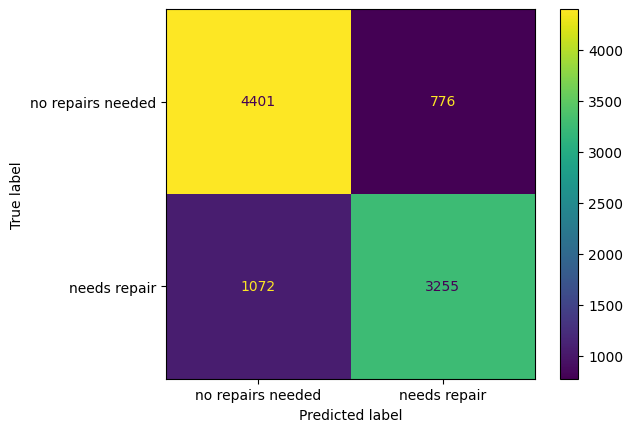

In [ ]:
# plot_confusion_matrix is outdated, we will have to use this instead
ConfusionMatrixDisplay.from_estimator(
    model,
    X_val,
    y_val,
    values_format='.0f',  # no scientific notation
    display_labels=['no repairs needed', 'needs repair']) # displays classes in sorted order, 0 means no repairs needed and 1 means repair needed
    # we are evaluating our model with validation data set, something the model hasn't seen before! And it also needs to have the true labels in it. so we can't use the
    # training set and we can't use the test set without labels

- True Positives (green), True Negatives (yellow), False Positives Type I Error (776), False Negatives Type II Error (1072)
- Precision: how many predicted positives are actually positive
- Recall: How many of the actual positives are correctly predicted

Remember: function is 0 (negative), needs repair is 1 (positive).

## Calculate accuracy, precision and recall by hand

**Accuracy Score**
- (True Pos + True Neg) / Everything =

In [ ]:
# calculate score by hand
 (4401 + 3255) / (1072 + 3255 + 4401 + 776)
# it matches our validation accuracy score from sklearn

0.8055555555555556

**Precision Score**

Of all the pumps that I predicted as needing repair (All predicted positives), this is the proportion actually needed repair (True positive):

In [ ]:
# precision = tp / (tp + fp)

In [ ]:
3255 / (3255+776)

0.8074919374844952

**Recall Score**

Of those pumps that actually needed repair (True Positive and False Negative), this is the proportion I correctly predicted as needing repair (True Positive).

In [ ]:
# recall tp / (tp + fn)

In [ ]:
3255 / (3255 + 1072)

0.7522532932747862

## Printed classication report

In [ ]:
classification_report(y_val,
                      model.predict(X_val),
                      target_names=['no repairs needed', 'repairs needed'])



'                   precision    recall  f1-score   support\n\nno repairs needed       0.80      0.85      0.83      5177\n   repairs needed       0.81      0.75      0.78      4327\n\n         accuracy                           0.81      9504\n        macro avg       0.81      0.80      0.80      9504\n     weighted avg       0.81      0.81      0.80      9504\n'

In [ ]:
# Use the print statement to have a more readable format
print(classification_report(y_val,
                      model.predict(X_val),
                      target_names=['no repairs needed', 'repairs needed']))

                   precision    recall  f1-score   support

no repairs needed       0.80      0.85      0.83      5177
   repairs needed       0.81      0.75      0.78      4327

         accuracy                           0.81      9504
        macro avg       0.81      0.80      0.80      9504
     weighted avg       0.81      0.81      0.80      9504



**F-score**
- F1-score is a harmonic mean of precision and recall
- F1-score = 2 * (precision * recall) / (precision + recall)
- in cases where both precision and recall are important, we wanna maximize our F1-score

**The balance between precision and recall**
- Some cases higher recall is better than low precision e.g. medical diagnosis. We care about how our true positive calls compare to the truth, not how they compare to all our positive calls. We need to reduce number of False Negatives.

- For YouTube recommendations, the precision matters more.
- water pump example: High recall gives priority to people who need access of water (reduce FN, water pumps that actually need repair but missed). High precision gives priority to reducing unnecessary costs (reduce FP, water pumps that actually don't need repair but we go and repair them anyway).
- At the end, it's the balance of profits and doing good.

# Case Study to show the importance of using a model for predictions

If it costs the Tanzanian government $100 to inspect a water pump, and there is only funding for 2000 pump inspections.

In [ ]:
n_inspections = 2000

Scenario 1: Choose pumps randomly. No model is used, strictly based on the ratio of functional vs non-functional pumps, like our baseline.

In [ ]:
y_val.value_counts(normalize=True)

0    0.544718
1    0.455282
Name: needs_repair, dtype: float64

In [ ]:
repair_prob = y_val.value_counts(normalize=True).min()
repair_prob

0.45528198653198654

In [ ]:
print('Inspections conducted:', n_inspections)
print('Pumps repaired:', int(n_inspections * repair_prob))
print('Funds wasted:', (int(n_inspections - n_inspections * repair_prob) * 100))
       # inspected pumps - pumps repaired are the pump inspections wasted, each pump inspection costs $100
       # we need int because pump is a whole number

Inspections conducted: 2000
Pumps repaired: 910
Funds wasted: 108900


In [ ]:
# If we choose pumps randomly, we could only repair less than half of the pumps, and we're losing more than half of the budget! That's not acceptable.

Scenario 2: Using our random forest model "out of the box"

In [ ]:
# create a dictionary and then convert it to a dataframe
data = {
    'y_val':y_val,
    'y_pred': model.predict(X_val)
}

results =pd.DataFrame(data)

In [ ]:
results.head()

,y_val,y_pred
id,,
8492.0,1,0
16772.0,1,1
19506.0,0,1
40301.0,1,1
61519.0,0,0


In [ ]:
# create a mask to filter out only those pumps which my model thinks repair is necessary
mask = (results['y_pred']==1)
sample = results[mask].sample(n_inspections) # out of all the ones I predicted needing repair, which is > 10K, but I only have budget for 2000 pumps, so I need to take a sample

In [ ]:
print('Inspections conducted:', n_inspections)
print('Pumps repaired:', int(sample['y_val'].sum())) # sum of the actual values column in the sample dataframe where all the predictions say repair needed, see how many match
print('Funds wasted:', int((n_inspections - sample['y_val'].sum()))*100)

Inspections conducted: 2000
Pumps repaired: 1607
Funds wasted: 39300


In [ ]:
# HUGE IMPROVEMENT IN REDUCING WASTE from wasting $100K to only $39

Scenario 3: This time I empasize **precision** in my model, and only select pumps that my model is very certain (`>0.85`) need repair.
- raising the threshold to consider a pump needs repair from 0.5 to 0.85, so more pumps inspected & repaired are actual broken pumps.
- lower threshold favors recall and places priority on people having access to water

- To increase the threshold, we need to increase the prediction probabilities, not the predictions themselves
- but decision trees don't have classification thresholds, unlike logistic regression
- The prediction probability, or the predict_proba method will give the proportion of trees in the ensemble
- Ensemble = grouping or cluster of weak learners to create a strong learner




In [ ]:
model.predict_proba(X_val)

array([[0.76, 0.24],
       [0.  , 1.  ],
       [0.04, 0.96],
       ...,
       [0.08, 0.92],
       [0.44, 0.56],
       [0.24, 0.76]])

In [ ]:
data = {
    'y_val':y_val,
    'y_pred_proba':model.predict_proba(X_val)[:,-1], # grab the very last column only, probability values ONLY for the positive class where it's 1
}

results =pd.DataFrame(data)

In [ ]:
threshold = 0.85

In [ ]:
mask = (results['y_pred_proba'] > threshold)
sample = results[mask].sample(n_inspections) # same concept as scenario 2

In [ ]:
print('Inspections conducted:', n_inspections)
print('Pumps repaired:', int(sample['y_val'].sum()))
print('Funds wasted:', int(n_inspections - sample['y_val'].sum())*100)


Inspections conducted: 2000
Pumps repaired: 1896
Funds wasted: 10400


In [ ]:
# wasted even less money because we're more aggressive with saving money and increasing precision
# Further reduced waste from $39K to $10K, and more non-functional pumps are being repaired

# Statistical modeling and ML rule!